# 變異prompt
設定初始的prompt 判斷漲跌並計算其準確率和期望值  
再拿最高的年化報酬率的prompt變異
建立stack 將prompt 依序由表現好排到表現差
然後將比較好的拿來變異
最好的promt變異五次如果準確率沒有提升，便將其刪除，改用第二好的prompt

使用期交所的歷史台指期資料  
存入的#yes #no #unknown日期是當天的日期，由前一天的新聞判斷  

# 版本
python 3.11.7

In [68]:
# %pip install mplfinance
# %pip install langchain
# %pip install -qU langchain-openai

In [69]:
import os
import textwrap
import math
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from langchain.schema.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display
from IPython.display import Markdown

# model = 'gpt-4o'
model = 'gpt-4o'
temperature = 1
top_p = 0.9
seed = 0

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

llm = ChatOpenAI(
            openai_api_key = os.getenv('OPENAI_API_KEY'),
            model=model,
            temperature=temperature,
            top_p=top_p,
            seed=seed,
            )

llm_mutate = ChatOpenAI(
            openai_api_key = os.getenv('OPENAI_API_KEY'),
            model=model,
            temperature=temperature,
            top_p=top_p,
            )

path_out = "out_mutate_tx/openai/"

# functions
step1 問LLM漲跌  
step2 變異

27行 可以調整batch size  

## 主程式

In [70]:
# 透過前一天的新聞判斷今日的股市走勢
import time
import os
import json
import pandas as pd
from datetime import datetime, timedelta

def analyze_prompt(stock_ids, st, et, init_prompt, mutate_prompt):
    path_price_his = (os.path.abspath(os.getcwd())) + "/history_data/tw/twii_history.csv"

    # 讀取CSV檔案
    df_price_his = pd.read_csv(path_price_his, encoding='utf-8')
    df_price_his['日期'] = pd.to_datetime(df_price_his['日期'], format='%Y%m%d')
    df_price_his = df_price_his[(st <= df_price_his['日期']) & (df_price_his['日期'] <= et)]

    idx = 1
    batch_size = 70
    output_data = {}  # 使用字典來存儲每一天的輸出數據

    while idx < len(df_price_his):
        batch = []
        for i in range(batch_size):
            if idx + i >= len(df_price_his):
                break

            # 取得前一日的日期
            news_date = df_price_his.iloc[idx + i]['日期'] 
            news_date -= timedelta(days=1)

            # 存儲所有股票的新聞資料
            text_news = ""
            for j, stock_id in enumerate(stock_ids):
                path_news_file = (os.path.abspath(os.getcwd())) + "/history_data/tw/news_title/" + stock_id + "news_title.json"
                with open(path_news_file, 'r', encoding='utf-8') as f:
                    news_data = json.load(f)
                    text_news = "權值股的熱門新聞標題"
                    text_news += f"{news_data[news_date.strftime('%Y%m%d')]} \n"

            # 設置初始消息列表，包括 SystemMessage 和第一個 HumanMessage
            messages = [
                ("system", "你是一個厲害的股市操盤手，專長是當日沖消"),
                ("human",
                f"""
                以下是台灣股市權值股的新聞標題，
                {text_news}

                請依據以下判斷依據判斷權值股對大盤（實際操作使用台指期）隔日開盤時買進收盤時賣出的獲利可能性
                {mutate_prompt}
                
                請綜合以上資訊，判斷明日當沖台指期是否可能獲利，有可能請則只回答#yes，否則只回答#no，如果無關則回答#unknown，請盡量不要回答 #unknown
                
                """)
            ]
            batch.append(messages)

        res = llm.batch(batch)

        for i in range(len(res)):
            # 被預測的日期
            date_str = df_price_his.iloc[idx + i]['日期'].strftime('%Y%m%d')
            output_data[date_str] = {
                "token": res[i].usage_metadata,
                "raw_data": res[i].content,
            }

        # time.sleep(60)
        idx += batch_size

    # 將所有輸出數據寫入到同一個json檔案中
    data = {
        "model": model,
        "temperature": temperature,
        "top_p": top_p,
        "seed": seed,
        "init_prompt": init_prompt,
        "mutate_prompt": mutate_prompt,
        "output_data": output_data,
    }
    
    return data

def mutating_prompt(text_in):
    messages = [
        ("human",
        f"""
        變異這個指令內容，並保留語意：{text_in}
        只要回答變體的指令內容即可
        """)
    ]
    response = llm_mutate.invoke(messages)
    # print(f'變異結果： {response.content}')
    # time.sleep(60)
    return response.content

In [71]:
# x = """讓我們逐步探討如何實現這些目標：

# 1. **企業創新策略**：這是我們所有努力的核心，不論是為了滿足客戶需求、吸引投資者，還是提升股價，我們的每一個行動都應圍繞這一策略展開。
# 2. **滿足客戶需求**：客戶需求是我們創新策略的首要驅動力，能否成功滿足這些需求將直接影響我們創新的成敗。
# 3. **吸引投資者關注**：投資者的關注和信心對於我們獲取必要的資金和支持至關重要，這也是我們創新成功的重要標誌。

# 讓我們在這條道路上穩步前進，確保每一步都踏實穩健。"""
# print(x)
# print("_"*50)
# x = mutating_prompt(x)
# print(x)

# 計算表現

In [72]:
import pandas as pd
import json
import os

def eval(anal_data):
    # 計算準確率和平均報酬率
    gain = []
    loss = []

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    token_input = 0
    token_output = 0

    path_price_his = (os.path.abspath(os.getcwd())) + "/history_data/tw/twii_history.csv"
    df_price_his = pd.read_csv(path_price_his, encoding='utf-8')
    df_price_his['日期'] = pd.to_datetime(df_price_his['日期'], format='%Y%m%d')

    output_data = anal_data["output_data"]
    for date_str, result in output_data.items():
        token_input += result["token"]["input_tokens"]
        token_output += result["token"]["output_tokens"]
        sig_str = result["raw_data"]
        sig = 0

        if "unknown" in sig_str:
            sig = 0
        elif "yes" in sig_str:
            sig = 1
        elif "no" in sig_str:
            sig = -1
        else:
            sig = 0

        df_price = df_price_his[df_price_his['日期'] == pd.to_datetime(date_str, format='%Y%m%d')]

        if df_price.empty:
            continue

        rtn = (df_price.iloc[0]['收盤指數'] - df_price.iloc[0]['開盤指數']) / df_price.iloc[0]['開盤指數']

        if pd.isna(rtn):
            rtn = 0

        if sig > 0:
            if rtn > 0:
                tp += 1
                gain.append(rtn)
            else:
                fp += 1
                loss.append(rtn)
        elif sig == -1:
            if rtn < 0:
                tn += 1
                gain.append(-rtn)
            else:
                fn += 1
                loss.append(-rtn)
    
    ev = 0
    accuracy = 0
    if tp + fp + tn + fn == 0:
        accuracy = 0
        ev = 0
    elif len(gain) == 0 or len(loss) == 0:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        ev = 0
    else:
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        ev = (sum(gain) / len(gain))*accuracy + (sum(loss) / len(loss))*(1-accuracy)

    eval_data = {
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "accuracy": accuracy,
        "ev": ev,
    }
    
    print(f'tp {tp}, fp {fp}, tn {tn}, fn {fn}, total:[{tp + fp + tn + fn}/{len(output_data)}]')
    print(f'Accuracy {round(accuracy, 5)}, Expected value:{round(ev,5)}')
    # print("--------------------")
    # print(f'token: input {token_input}, output {token_output}')
    # print(f'預估費用 {(token_input/1000000)*0.35 + (token_output/1000000)*0.7} USD, {((token_input/1000000)*0.35 + (token_output/1000000)*0.7)*32.6} TWD')
    # print(f'詢問次數 {len(output_data)}')
    # print()

    return accuracy, ev, eval_data

## 輸出

In [73]:
def save_data(folder_path, data):
    count = 1
    out_file = ""
    while True:
        if os.path.exists(folder_path + str(count) + ".json"):
            count += 1
        else:
            out_file = folder_path + str(count) + ".json"
            break
    json_content = json.dumps(data, ensure_ascii=False, indent=4)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    with open(out_file, "w", encoding="UTF-8") as f:
        f.write(json_content)
    
    print(f"已儲存至{out_file}")
    return out_file

# 訓練
6 7 設定執行日期  
8 權值股的股票代號 ['2308', '2317', '2330', '2382', '2412', '2454', '2881', '2882', '2891', '6505']  
20 輸出檔案路徑
60 設定變異次數上限

In [74]:
# 避免local minimum
from datetime import datetime

# 初始化
run_count = 1
start_day = datetime(2023, 6, 1)
end_day = datetime(2024, 5, 30)
out_folder = start_day.strftime('%Y%m%d') + "_" + end_day.strftime('%Y%m%d')
stock_ids = ['2308', '2317', '2330', '2382', '2412', '2454', '2881', '2882', '2891', '6505']
init_acc = 0
acc = 0
init_prompt = """
讓我們一步一步來
利多需要滿足以下條件：
企業創新策略：這是所有句子的核心主題，無論是滿足客戶需求、吸引投資者，還是促進股價增長，都是基於企業的創新策略。
滿足客戶需求：客戶需求是企業創新的首要驅動力，能否滿足客戶需求直接影響創新成敗。
吸引投資者關注：投資者的關注和信心能為企業提供必要的資金和支持，也是創新成功的重要標誌。
"""
prompt_stack = [(init_prompt, acc)]  # 初始prompt和準確率加入stack
mutate_count = 0  # 記錄變異次數
current_prompt, init_acc = prompt_stack[-1]

In [75]:
# 主迴圈
while prompt_stack:
    print(f"Run count: {run_count}")
    current_prompt, _ = prompt_stack[-1]  # 取得stack頂部的prompt和準確率
    mutate_prompt = init_prompt
    mutate_prompt = mutating_prompt(current_prompt)  # 生成變異prompt
    data_anal = analyze_prompt(stock_ids, start_day, end_day, current_prompt, mutate_prompt)
    acc, ev, data_eval = eval(data_anal)
    mutate_count += 1

    # 將新的prompt和準確率加入stack，並按準確率排序
    prompt_stack.append((mutate_prompt, acc))
    prompt_stack.sort(key=lambda x: x[1])  # 按準確率由低至高排序

    # 有比stack更高的準確率則將 counter 重置
    if acc > _:
        init_acc = acc
        mutate_count = 0  # 重置變異次數計數器
        print(f"Update prompt with accuracy: {acc}")

    if len(prompt_stack) > 1 and mutate_count >= 2:
        prompt_stack.pop()  # 移除準確率最高的prompt 避免local minimum
        mutate_count = 0  # 重置變異次數計數器
        print("Remove top prompt due to no improvement after 5 mutations.")
    elif acc > 0.9:
        acc = 0.6
        prompt_stack.pop()  # 移除準確率最高的prompt 避免local minimum
        mutate_count = 0  # 重置變異次數計數器
        print("Remove top prompt due to accuracy over 0.9.")
    elif len(prompt_stack) == 1:
        # 如果stack只剩下一個prompt，移除變異次數限制
        mutate_count = 0
        print("Single prompt in stack, removing mutation limit.")

    # # 輸出本次變異
    # print(prompt_stack)
    # print(mutate_count)
    # 終止條件
    run_count += 1

    print(data_eval)
    data_anal['eval_data'] = data_eval
    json_content = json.dumps(data_anal, ensure_ascii=False, indent=4)
    save_data(f"{path_out}train/{out_folder}/", data_anal)

    # # 設定變異次數上限
    # if acc > 0.7:
    #     print("Accuracy over 0.7, stop training.")
    #     trained_prompt = prompt_stack[-1][0]
    #     print(f"Final prompt:")
    #     print(trained_prompt)
    #     break
    # el
    if run_count > 40:
        print("Run count over, stop training.")
        trained_prompt = prompt_stack[-1][0]
        print(f"Final prompt:")
        print(trained_prompt)
        break

Run count: 1
tp 66, fp 41, tn 29, fn 43, total:[179/242]
Accuracy 0.53073, Expected value:0.00114
Update prompt with accuracy: 0.5307262569832403
{'tp': 66, 'fp': 41, 'tn': 29, 'fn': 43, 'accuracy': 0.5307262569832403, 'ev': 0.0011416870917039827}
已儲存至out_mutate_tx/openai/train/20230601_20240530/1.json
Run count: 2
tp 65, fp 40, tn 23, fn 40, total:[168/242]
Accuracy 0.52381, Expected value:0.00122
{'tp': 65, 'fp': 40, 'tn': 23, 'fn': 40, 'accuracy': 0.5238095238095238, 'ev': 0.001219368123832401}
已儲存至out_mutate_tx/openai/train/20230601_20240530/2.json
Run count: 3
tp 70, fp 44, tn 24, fn 35, total:[173/242]
Accuracy 0.54335, Expected value:0.00127
Update prompt with accuracy: 0.5433526011560693
{'tp': 70, 'fp': 44, 'tn': 24, 'fn': 35, 'accuracy': 0.5433526011560693, 'ev': 0.0012658152833041811}
已儲存至out_mutate_tx/openai/train/20230601_20240530/3.json
Run count: 4
tp 68, fp 40, tn 30, fn 37, total:[175/242]
Accuracy 0.56, Expected value:0.00126
Update prompt with accuracy: 0.56
{'tp': 6

In [43]:
prompt_stack = [('\n讓我們一步一步來\n利多需要滿足以下條件：\n企業創新策略：這是所有句子的核心主題，無論是滿足客戶需求、吸引投資者，還是促進股價增長，都是基於企業的創新策略。\n滿足客戶需求：客戶需求是企業創新的首要驅動力，能否滿足客戶需求直接影響創新成敗。\n吸引投資者關注：投資者的關注和信心能為企業提供必要的資金和支持，也是創新成功的重要標誌。\n', 0), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新改寫的版本：\n\n要逐步探討實現利多的關鍵條件，我們可以從以下幾個方面入手：\n\n1. **制定創新策略**：這是所有條件中的核心。不論是為了滿足客戶需求、吸引投資者，還是提升股價，創新策略都是企業的根本所在。\n\n2. **滿足客戶需求**：客戶需求是推動創新策略的主要力量。能否有效地滿足這些需求，將直接影響創新成果的成功與否。\n\n3. **吸引投資者**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新成功的重要指標之一。\n\n總之，成功的創新策略應該在滿足客戶需求的同時，吸引投資者的關注和支持。', 0.5573770491803278), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新組織後的變體，仍保留原本的語意：\n\n讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了提升股價、滿足客戶需求，還是吸引投資者，企業的創新策略是根本所在。\n\n2. **滿足客戶需求**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接決定創新成果的成敗。\n\n3. **吸引投資者**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。', 0.5689655172413793), ('讓我們逐步探討利多所需的條件：\n\n1. **企業創新策略**：這是所有條件的核心，無論是滿足客戶需求、吸引投資者，還是促進股價增長，這一切都基於企業的創新策略。\n\n2. **滿足客戶需求**：客戶需求是企業創新的首要驅動力，能否滿足這些需求直接決定了創新的成敗。\n\n3. **吸引投資者關注**：投資者的關注和信心能為企業提供必要的資金和支持，這也是創新成功的重要標誌。\n\n總之，成功的企業創新策略應該能夠同時滿足客戶需求和吸引投資者的關注。', 0.5714285714285714), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新組織後的變體：\n\n要逐步探討實現利多所需的關鍵條件，我們需要關注以下幾個方面：\n\n1. **創新策略的制定**：這是所有關鍵條件中的核心。企業必須制定有效的創新策略，無論目標是滿足客戶需求、吸引投資者，還是提升股價，創新策略都是實現這些目標的基礎。\n\n2. **滿足客戶需求**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新的成果和成敗。\n\n3. **吸引投資者**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要標誌。\n\n綜上所述，成功的創新策略必須能夠同時滿足客戶需求並吸引投資者的注意。', 0.59375), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **企業創新策略**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，一切都源於企業的創新策略。\n\n2. **滿足客戶需求**：客戶需求是企業創新的首要驅動力。能否成功滿足這些需求，直接決定了創新能否取得成功。\n\n3. **吸引投資者關注**：投資者的關注和信心為企業提供了必要的資金和支持，也是創新成功的重要標誌。\n\n綜上所述，成功的企業創新策略應同時滿足客戶需求並吸引投資者的關注。', 0.5970149253731343), ('讓我們分步探討實現利多所需的條件：\n\n1. **企業創新策略**：這是所有條件的核心所在。無論是為了滿足客戶需求、吸引投資者，還是促進股價增長，一切都源於企業的創新策略。\n\n2. **滿足客戶需求**：客戶需求是企業創新的首要驅動力。能否成功滿足這些需求，直接決定了創新能否取得成功。\n\n3. **吸引投資者關注**：投資者的關注和信心為企業提供了必要的資金和支持，也是創新成功的重要標誌。\n\n總而言之，成功的企業創新策略應當同時滿足客戶需求並吸引投資者的關注。', 0.6031746031746031), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **企業創新策略**：這是所有條件中的核心。不論是為了滿足客戶需求、吸引投資者，還是提升股價，一切都圍繞企業的創新策略展開。\n\n2. **滿足客戶需求**：客戶需求是推動企業創新的主要力量。能否成功滿足這些需求，將直接影響創新成果的成功與否。\n\n3. **吸引投資者注意**：投資者的注意和信任為企業提供了所需的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的企業創新策略必須同時滿足客戶需求並吸引投資者的注意。', 0.6031746031746031), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新組織後的變體：\n\n要逐步探討實現利多的關鍵條件，我們需要關注以下幾點：\n\n1. **創新策略的制定**：這是實現目標的核心環節。無論是為了迎合客戶需求、吸引投資者，還是提升企業的市場價值，制定有效的創新策略是必不可少的。\n\n2. **滿足客戶需求**：客戶需求是推動創新的主要動力。能否有效地識別和滿足這些需求，將直接決定創新項目的成功與否。\n\n3. **吸引投資者**：投資者的興趣和信任能為企業帶來必要的資金和資源支持，這也是衡量創新策略成效的重要標準。\n\n總結來說，成功的創新策略需要在滿足客戶需求的同時，獲得投資者的青睞和支持。', 0.6101694915254238), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引與信任**：吸引投資者的關注和信心，為企業提供了必要的資金和支持，也是創新成功的重要指標。\n\n綜合以上觀點，一個成功的企業創新策略必須能同時滿足客戶需求並吸引投資者的關注。', 0.6176470588235294), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **企業創新策略**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，一切都源於企業的創新策略。\n\n2. **滿足客戶需求**：客戶需求是企業創新的首要驅動力。能否成功滿足這些需求，直接關係到創新能否取得成功。\n\n3. **吸引投資者關注**：投資者的關注和信心為企業提供了必要的資金和支持，也是創新成功的重要標誌。\n\n綜上所述，成功的企業創新策略應同時滿足客戶需求並吸引投資者的關注。', 0.625), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新改寫的版本：\n\n要逐步探討實現利多的關鍵條件，我們可以從以下幾個方面入手：\n\n1. **制定創新策略**：這是所有條件中的核心。不論是為了滿足客戶需求、吸引投資者，還是提升股價，創新策略都是根本。\n\n2. **滿足客戶需求**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新的成敗。\n\n3. **吸引投資者**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總結來說，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的注意力。', 0.6307692307692307), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **企業創新策略**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，一切都基於企業的創新策略。\n\n2. **滿足客戶需求**：客戶需求是企業創新的首要驅動力。能否成功滿足這些需求，直接影響到創新成果的成敗。\n\n3. **吸引投資者關注**：投資者的關注和信心為企業提供了必要的資金和支持，這也是創新能否成功的重要指標。\n\n綜上所述，成功的企業創新策略必須同時滿足客戶需求並吸引投資者的關注。', 0.6379310344827587)]
print(prompt_stack)

[('\n讓我們一步一步來\n利多需要滿足以下條件：\n企業創新策略：這是所有句子的核心主題，無論是滿足客戶需求、吸引投資者，還是促進股價增長，都是基於企業的創新策略。\n滿足客戶需求：客戶需求是企業創新的首要驅動力，能否滿足客戶需求直接影響創新成敗。\n吸引投資者關注：投資者的關注和信心能為企業提供必要的資金和支持，也是創新成功的重要標誌。\n', 0), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新改寫的版本：\n\n要逐步探討實現利多的關鍵條件，我們可以從以下幾個方面入手：\n\n1. **制定創新策略**：這是所有條件中的核心。不論是為了滿足客戶需求、吸引投資者，還是提升股價，創新策略都是企業的根本所在。\n\n2. **滿足客戶需求**：客戶需求是推動創新策略的主要力量。能否有效地滿足這些需求，將直接影響創新成果的成功與否。\n\n3. **吸引投資者**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新成功的重要指標之一。\n\n總之，成功的創新策略應該在滿足客戶需求的同時，吸引投資者的關注和支持。', 0.5573770491803278), ('讓我們逐步探討實現利多所需的關鍵條件：\n\n1. **創新策略的制定**：這是所有條件中的核心。無論是為了滿足客戶需求、吸引投資者，還是提升股價，企業的創新策略是根本所在。\n\n2. **客戶需求的滿足**：客戶需求是創新策略的主要驅動力。能否有效地滿足這些需求，將直接影響創新成果的成敗。\n\n3. **投資者的吸引**：投資者的關注和信心為企業提供必要的資金和支持，這也是創新能否成功的重要指標。\n\n總而言之，成功的創新策略必須在滿足客戶需求的同時，吸引投資者的關注。\n\n以下是重新組織後的變體，仍保留原本的語意：\n\n讓我們逐步探討實

# 測試
6/1~ 8/31

In [108]:
trained_prompt = prompt_stack[-1][0]
trained_prompt = f"""我們依次實現以下優勢：

1. 企業創新策略：這是所有因素的核心，不論是滿足客戶需求、吸引投資者，還是提升股價，都依賴於企業的創新策略。

2. 滿足客戶需求：客戶需求是企業創新的主要驅動力，能否滿足這些需求直接影響創新的成敗。

3. 吸引投資者關注：投資者的關注和信任為企業提供必要的資金和支持，是創新成功的重要標誌。


"""

start_day = datetime(2024, 6, 1)
end_day = datetime(2024, 8, 31)
accs = []
evs = []

# for i in range(len(prompt_over60)):
data_anal = analyze_prompt(stock_ids, start_day, end_day, trained_prompt, trained_prompt)
acc, ev, data_eval = eval(data_anal)
data_anal['eval_data'] = data_eval
json_content = json.dumps(data_anal, ensure_ascii=False, indent=4)
save_data(f"{path_out}test/{out_folder}/", data_anal)
accs.append(acc)
evs.append(ev)

print(sum(accs) / len(accs), sum(evs) / len(evs))   

tp 20, fp 11, tn 8, fn 17, total:[56/61]
Accuracy 0.5, Expected value:-0.00079
已儲存至out_mutate_tx/openai/test/20230601_20240530/5.json
0.5 -0.0007913374924016681


# DEMO

In [78]:
#檢查這個路徑下有多少檔案
import os
path = f"{path_out}train/{out_folder}/"
files = os.listdir(path)
files = sorted(files)

prompt_over60 = []
x = 0

for file in files:

    with open(path + file, "r", encoding="utf-8") as f:
        file_content = json.load(f)

    # print(file_content['eval_data'])
    if file_content['eval_data']['accuracy'] > 0.55:
        print(file_content['mutate_prompt'])
        x += 1
        print(x)
        print(file_content['eval_data']['accuracy'])
        prompt_over60.append(file_content['mutate_prompt'])
    print("_" * 50)

print(len(prompt_over60))
print(prompt_over60)

__________________________________________________
__________________________________________________
__________________________________________________
以下優勢逐步實現：

1. 企業創新策略：這是公司所有方面的基礎，無論是滿足客戶需求、吸引投資者，還是提升股價，都取決於企業的創新策略。
2. 滿足客戶需求：客戶需求是公司創新推動的主要驅動力，能否滿足這些需求直接決定創新的成敗。
3. 吸引投資者關注：投資者的注意和信任為公司提供必要的資金和支持，是創新成功的關鍵標誌。
1
0.5649717514124294
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
以下是變異後仍保留語意的指令內容：

讓我們逐步實現以下優勢：

1. 企業創新策略：這是所有環節的核心，無論是滿足客戶需求、吸引投資者，還是提升股價，都依賴於企業的創新策略。
2. 滿足客戶需求：客戶需求是企業創新的主要驅動力，能否滿足這些需求直接關係到創新的成敗。
3. 吸引投資者關注：投資者的關注和信任為企業提供必要的資金和支持，這也是創新成功的重要標誌。
2
0.5657142857142857
_

In [46]:
# #檢查這個路徑下有多少檔案
# import os
# path = f"{path_out}test/{out_folder}/"
# files = os.listdir(path)
# files = sorted(files)
# tp = 0
# fp = 0
# tn = 0
# fn = 0

# for file in files:
#     print(file)
#     with open(path + file, "r", encoding="utf-8") as f:
#         file_content = json.load(f)
#     # print(file_content['mutate_prompt'])
#     print(file_content['eval_data'])
#     tp += file_content['eval_data']['tp']
#     fp += file_content['eval_data']['fp']
#     tn += file_content['eval_data']['tn']
#     fn += file_content['eval_data']['fn']
#     print("_" * 50)
# print(tp, fp, tn, fn)
# print("accuracy:", (tp + tn) / (tp + fp + tn + fn))

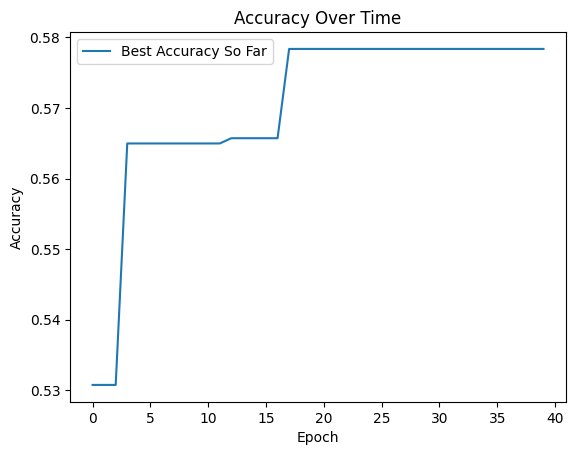

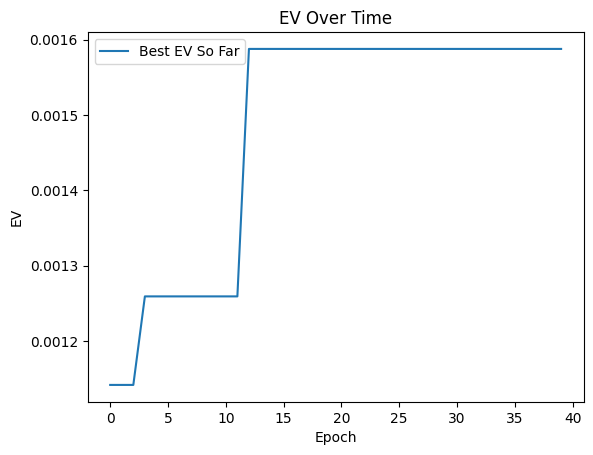

In [79]:
import json
import matplotlib.pyplot as plt
import os

accs = []
evs = []
best_accs = []
best_evs = []
best_acc = float('-inf')  # 初始化為負無窮
best_ev = float('-inf')  # 初始化為負無窮

path = f"{path_out}train/{out_folder}/"
files = os.listdir(path)
files = sorted(files)

for file in files:
    outpath = f"{path_out}train/{out_folder}/" + file
    with open(outpath, 'r', encoding='utf-8') as f:
        data = json.load(f)
        acc = data['eval_data']['accuracy']
        ev = data['eval_data']['ev']

    if acc > 0.7:
        continue

    # 追加目前的 acc 和 ev
    accs.append(acc)
    evs.append(ev)

    # 追蹤到目前為止的最佳 acc 和 ev
    if acc > best_acc:
        best_acc = acc
    if ev > best_ev:
        best_ev = ev

    # 追加最佳 acc 和 ev 的數值
    best_accs.append(best_acc)
    best_evs.append(best_ev)

# 繪製 Accuracy 圖表
# plt.plot(accs, label='Accuracy')
plt.plot(best_accs, label='Best Accuracy So Far')
plt.title('Accuracy Over Time')  # 添加標題
plt.xlabel('Epoch')  # X軸標籤
plt.ylabel('Accuracy')  # Y軸標籤
plt.legend()  # 顯示圖例
plt.show()

# 繪製 EV 圖表
# plt.plot(evs, label='EV')
plt.plot(best_evs, label='Best EV So Far')
plt.title('EV Over Time')  # 添加標題
plt.xlabel('Epoch')  # X軸標籤
plt.ylabel('EV')  # Y軸標籤
plt.legend()  # 顯示圖例
plt.show()
